## Neural Network for Number Detection

### Downloading Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

### For GPU Processing

In [2]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()


def to_device(data, device):
    """Move tensor to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]    #list or tuple
    return data.to(device, non_blocking=True)          #for tensors or models

### Make Datasets

In [3]:
dataset = MNIST(root='data/', download=True, transform=transforms.ToTensor())  #MNIST class is used as a constructor

test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
len(test_dataset)

10000

### Preparing Dataloaders

In [4]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

from torch.utils.data import random_split

batch_size = 128
validation_size = 10000
train_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset, [train_size, validation_size])  #randomly splits the dataset so that validation isn't just the last 10k images

In [5]:
class DeviceDataLoader():
    #wrap a dataloader to move data to a device
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        # yeilds the next batch of data after moving it to device
        for b in self.dl:
            yield to_device(b, self.device)   # yeild is used to create a generator function which can be iterated in a for loop

    def __len__(self):
        #number of batches
        return len(self.dl)

In [6]:
train_loader = DeviceDataLoader(DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True), device)
val_loader = DeviceDataLoader(DataLoader(val_ds, batch_size=batch_size*2, num_workers=4, pin_memory=True), device)
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=batch_size*2, num_workers=4, pin_memory=True), device)

In [7]:
input_size = 28 * 28
num_classes = 10
hidden_size1 = 128
hidden_size2 = 16

### Defining Accuracy

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

### Extending nn.module

In [9]:
class MNIST(nn.Module):
    def __init__(self, in_size, hidden_size1, hidden_size2, num_classes):
        super().__init__()
        self.Sequential = nn.Sequential(
            nn.Linear(input_size, hidden_size1),
            nn.ReLU(),
            nn.Linear(hidden_size1, hidden_size2),
            nn.ReLU(),
            nn.Linear(hidden_size2, num_classes),)

    def forward(self, xb):
        xb = xb.view(xb.size(0), -1)
        outputs = self.Sequential(xb)
        return outputs
    
    def training_step(self, batch):
        images, labels = batch
        outputs = self(images)                    # gen preds
        loss = F.cross_entropy(outputs, labels)   # calc loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        outputs = self(images)                      # gen preds
        loss = F.cross_entropy(outputs, labels)     # calc loss
        acc = accuracy(outputs, labels)             # calc acc
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()             # combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()                # combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}%".format(epoch+1, result['val_loss'], result['val_acc']*100))


Defining Model and Loading the Weights and Parameters of the model which we already trained (if not then run the training cell)

In [10]:
model = MNIST(input_size, hidden_size1, hidden_size2, num_classes)
to_device(model, device)
model.load_state_dict(torch.load('mnist_weights.pth'))

<All keys matched successfully>

In [11]:
#for images, labels in train_loader:
    #outputs = model(images)
    #break

#print(outputs.shape)   #but the prob are neg and dont add upto 1
#print(outputs[:2].data)

### Defining the evaluate and fit func

In [12]:
def evaluate(model, val_loader):
    #Evaluates model on validation set
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



def fit(epochs, lr, model, train_loader, val_loader, opt_fn = torch.optim.SGD):
    #Trains model using gradient descent
    optimizer = opt_fn(model.parameters(), lr)   # model.parameter contains all the weights and biases of the model and gets passed to optimizer
    history = []

    for epoch in range(epochs):
        #train
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        #validate
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

### Training

In [15]:
result0 = evaluate(model, val_loader)       # gives initial loss and acc
print("Initial result: loss = {:.4f}, acc = {:.4f}%".format(result0['val_loss'], result0['val_acc']*100))   # print result0

history = fit(5, 0.01, model, train_loader, val_loader)    # trains the model and returns history of loss and acc through epochs
print(history)

Initial result: loss = 0.0380, acc = 98.7988%
Epoch [1], val_loss: 0.0349, val_acc: 98.9453%
Epoch [2], val_loss: 0.0349, val_acc: 98.9453%
Epoch [3], val_loss: 0.0348, val_acc: 98.9453%
Epoch [4], val_loss: 0.0345, val_acc: 98.9551%
Epoch [5], val_loss: 0.0349, val_acc: 98.9355%
[{'val_loss': 0.034923505038022995, 'val_acc': 0.989453136920929}, {'val_loss': 0.0348522774875164, 'val_acc': 0.989453136920929}, {'val_loss': 0.0348169170320034, 'val_acc': 0.989453136920929}, {'val_loss': 0.034480612725019455, 'val_acc': 0.989550769329071}, {'val_loss': 0.03485342860221863, 'val_acc': 0.9893554449081421}]


### Testing

Predicted: 7Actual: 7


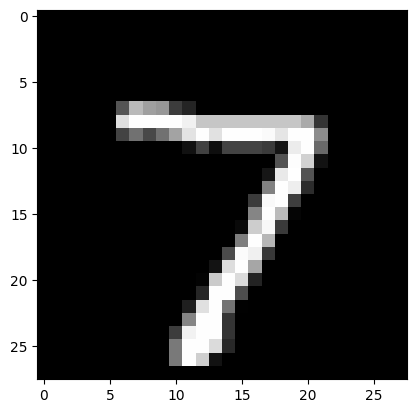

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)     # img tensor get conv to a batch of image tensors (basically adds an extra dimension)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()


img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Predicted:', predict_image(img, model),end='  ')
print('Actual:', label)

In [17]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=batch_size*2, num_workers=4, pin_memory=True), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.06460074335336685, 'val_acc': 0.98046875}

### Save and Upload

In [18]:
saved_weights_fname = 'mnist_weights.pth'
torch.save(model.state_dict(), saved_weights_fname)    # state_dict() returns an ordered dict of all the weights and biases of the model